In [1]:
from rs_graph.bin.modeling import _create_dataset_for_document_repository_training

data = _create_dataset_for_document_repository_training()

data.sample(3)

/Users/evamaxfield/micromamba/envs/rs-graph/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,dataset_source,document_id,document_doi,document_title,document_abstract,document_publication_date,document_contributor_names,repository_id,repository_name,repository_description,repository_creation_date,repository_contributor_usernames,repository_contributor_names,repository_contributor_emails,match
7963,2,2246,10.48550/arxiv.2310.18921,QWID: Quantized Weed Identification Deep neura...,"In this paper, we present an efficient solutio...",2023-01-01,Parikshit Singh Rathore,2237,qnn-for-weed,None,2023-10-08,parikshit14,Parikshit Singh Rathore,,match
2561,-1,2439,10.48550/arxiv.1805.12402,Breaking-down the Ontology Alignment Task with...,Large ontologies still pose serious challenges...,2018-01-01,"Ernesto Jiménez-Ruiz, Asan Agibetov, Matthias ...",3902,libemmi,Library for 3D electromagnetic modelling and i...,2023-04-26,yangpl,Pengliang Yang,ypl.2100@gmail.com,no-match
7433,-1,3979,10.48550/arxiv.2011.00844,Do 2D GANs Know 3D Shape? Unsupervised 3D shap...,Natural images are projections of 3D objects o...,2020-01-01,"Ping Luo, Chen Change Loy, Xingang Pan, Bo Dai...",2954,aibot_fox8,This repo contains the code and information fo...,2023-06-10,yang3kc,Kaicheng(Kevin) Yang,yang3kc@gmail.com,no-match


In [2]:
from sentence_transformers import SentenceTransformer
import pandas as pd
from scipy.stats import zscore

# for each row, we want the following features:
# text embedding of the document title and abstract (joined together)
# text embedding of the contributor comparisons
# and difference in publication and repository creation date

doc_meta_template = """
Title: {doc_title}
Abstract: {doc_abstract}
""".strip()

repo_meta_template = """
Repository Details:

Name: {repo_name}
Description: {repo_description}
""".strip()

doc_contributor_template = """
Document Contributors:

Names: {doc_contributor_names}
""".strip()

repo_contributor_template = """
Repository Contributors:

Usernames: {repo_contributor_usernames}
Names: {repo_contributor_names}
Emails: {repo_contributor_emails}
""".strip()

doc_meta_templates = [
    doc_meta_template.format(
        doc_title=str(row["document_title"]),
        doc_abstract=str(row["document_abstract"]),
    )
    for _, row in data.iterrows()
]

repo_meta_templates = [
    repo_meta_template.format(
        repo_name=str(row["repository_name"]),
        repo_description=str(row["repository_description"]),
    )
    for _, row in data.iterrows()
]

doc_contributor_templates = [
    doc_contributor_template.format(
        doc_contributor_names=str(row["document_contributor_names"]),
    )
    for _, row in data.iterrows()
]

repo_contributor_templates = [
    repo_contributor_template.format(
        repo_contributor_usernames=str(row["repository_contributor_usernames"]),
        repo_contributor_names=str(row["repository_contributor_names"]),
        repo_contributor_emails=str(row["repository_contributor_emails"]),
    )
    for _, row in data.iterrows()
]

timedeltas = zscore(
    (
        pd.to_datetime(data["repository_creation_date"])
        - pd.to_datetime(data["document_publication_date"])
    ).dt.days.tolist()
)

In [3]:
embed_model = SentenceTransformer("all-distilroberta-v1")

doc_meta_embeddings = embed_model.encode(doc_meta_templates, show_progress_bar=True)
# Comes back as a 2d numpy array, we want rows with columns of
# "doc_meta_dim_1", "doc_meta_dim_2", ..., "doc_meta_dim_n"
doc_meta_embeddings = pd.DataFrame(
    doc_meta_embeddings,
    columns=[f"doc_meta_dim_{i}" for i in range(doc_meta_embeddings.shape[1])]
)

repo_meta_embeddings = embed_model.encode(repo_meta_templates, show_progress_bar=True)
# Comes back as a 2d numpy array, we want rows with columns of
# "repo_meta_dim_1", "repo_meta_dim_2", ..., "repo_meta_dim_n"
repo_meta_embeddings = pd.DataFrame(
    repo_meta_embeddings,
    columns=[f"repo_meta_dim_{i}" for i in range(repo_meta_embeddings.shape[1])]
)

doc_contributor_embeddings = embed_model.encode(doc_contributor_templates, show_progress_bar=True)
# Comes back as a 2d numpy array, we want rows with columns of
# "doc_contributor_dim_1", "doc_contributor_dim_2", ..., "doc_contributor_dim_n"
doc_contributor_embeddings = pd.DataFrame(
    doc_contributor_embeddings,
    columns=[f"doc_contributor_dim_{i}" for i in range(doc_contributor_embeddings.shape[1])]
)

repo_contributor_embeddings = embed_model.encode(repo_contributor_templates, show_progress_bar=True)
# Comes back as a 2d numpy array, we want rows with columns of
# "repo_contributor_dim_1", "repo_contributor_dim_2", ..., "repo_contributor_dim_n"
repo_contributor_embeddings = pd.DataFrame(
    repo_contributor_embeddings,
    columns=[f"repo_contributor_dim_{i}" for i in range(repo_contributor_embeddings.shape[1])]
)

# Concat all embeddings / features into a single df
features = pd.concat(
    [
        doc_meta_embeddings,
        repo_meta_embeddings,
        doc_contributor_embeddings,
        repo_contributor_embeddings,
        pd.DataFrame({"repo_creation_to_publication_date_delta_days": timedeltas}),
        pd.DataFrame({"label": data["match"]})
    ],
    axis=1,
)

features.sample(3)

Batches: 100%|██████████| 271/271 [00:30<00:00,  8.90it/s]


,doc_meta_dim_0,doc_meta_dim_1,doc_meta_dim_2,doc_meta_dim_3,doc_meta_dim_4,doc_meta_dim_5,doc_meta_dim_6,doc_meta_dim_7,doc_meta_dim_8,doc_meta_dim_9,...,repo_contributor_dim_760,repo_contributor_dim_761,repo_contributor_dim_762,repo_contributor_dim_763,repo_contributor_dim_764,repo_contributor_dim_765,repo_contributor_dim_766,repo_contributor_dim_767,repo_creation_to_publication_date_delta_days,label
394,-0.021979,-0.073870,-0.020523,0.038290,-0.016355,0.046586,0.008713,0.062338,0.030798,-0.009368,...,0.010433,0.012961,0.013698,-0.003720,0.083371,-0.022865,-0.020421,0.025301,-0.651820,no-match
5952,0.061563,0.006880,-0.013285,-0.000042,0.015795,0.011623,-0.034170,0.011041,0.029332,0.045209,...,0.015968,-0.002350,0.017718,-0.024374,0.080157,-0.013404,-0.027282,0.015366,-0.416710,match
3789,0.001538,-0.030437,0.047780,-0.020390,-0.054296,0.029692,-0.019286,0.008596,0.013374,0.015843,...,-0.016831,0.001525,0.032001,-0.019234,0.081695,-0.018958,-0.004972,0.016514,0.450037,match


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

train_df, test_df = train_test_split(
    features,
    test_size=0.2,
    stratify=features["label"],
    random_state=42,
    shuffle=True,
)

clf = MLPClassifier(
    random_state=42,
    max_iter=1000,
)
clf = clf.fit(
    train_df.drop(columns=["label"]),
    train_df["label"],
)

In [5]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, ConfusionMatrixDisplay

test_preds = clf.predict(test_df.drop(columns=["label"]))

accuracy = accuracy_score(test_df["label"], test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    test_df["label"],
    test_preds,
    average="binary",
    pos_label="match",
)
accuracy, precision, recall, f1

(0.80473714615829, 0.785097192224622, 0.8394919168591224, 0.8113839285714285)

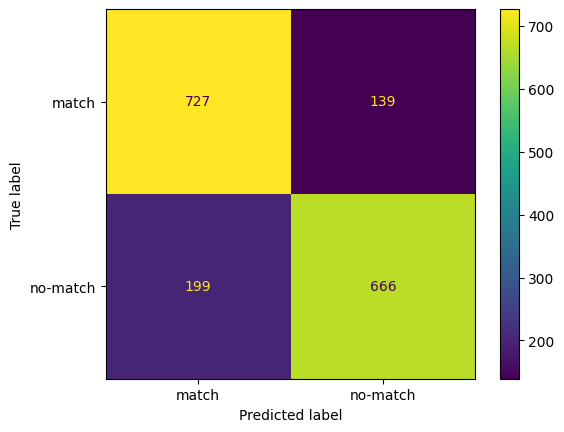

In [6]:
ConfusionMatrixDisplay.from_predictions(
    test_df["label"],
    test_preds,
)